# Analysis from scratch 

This notebook details the construction of an analysis pipeline for a healthcare costing dataset using only python in-built functions, `numpy`, `matplotplib`, and `Pandas`. The analysis pipeline includes the following steps:
1. exploration
1. preprocessing
1. model selection using a ridge regression model
1. prediction


In [2]:
# Library imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('mode.chained_assignment',None)

## Exploration

The healthcare costing dataset consists of features that describes the patient and the associated healthcare costs. The descriptive features of the patients includes:
- age
- gender
- bmi
- number of children
- if they are a smoker
- region for healthcare services

In [3]:
data = pd.read_csv('train.csv')
data.head()

,age,gender,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Distribution of categorical variables

In [4]:
print('Gender distribution: \n')
print(data['gender'].value_counts())

print('\nSmoker distribution: \n')
print(data['smoker'].value_counts())

print('\nRegion distribution: \n')
print(data['region'].value_counts())

Gender distribution: 

male      505
female    495
Name: gender, dtype: int64

Smoker distribution: 

no     804
yes    196
Name: smoker, dtype: int64

Region distribution: 

southeast    278
northeast    247
southwest    244
northwest    231
Name: region, dtype: int64


### Distribution of continuous and mapped categorical variables

In [5]:
data['gender'] = data['gender'].map({'male':-.5,'female':.5})
data['smoker'] = data['smoker'].map({'no':-.5,'yes':.5})
data['region'] = data['region'].map({'southeast':1,'northeast':2,'southwest':3,'northwest':4})
data.describe()

,age,gender,bmi,children,smoker,region,charges
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,39.615000,-0.005000,30.86338,1.080000,-0.304000,2.428000,13075.755883
std,14.153908,0.500225,6.04744,1.198765,0.397167,1.124313,11985.924552
min,18.000000,-0.500000,15.96000,0.000000,-0.500000,1.000000,1121.873900
25%,27.000000,-0.500000,26.60000,0.000000,-0.500000,1.000000,4719.683425
50%,40.000000,-0.500000,30.59000,1.000000,-0.500000,2.000000,9283.021300
75%,52.000000,0.500000,35.11250,2.000000,-0.500000,3.000000,15882.795437
max,64.000000,0.500000,50.38000,5.000000,0.500000,4.000000,63770.428010


### Correlations of features: main effects, and interactions

               age    gender       bmi  children    smoker    region   charges
age       1.000000  0.049141  0.116272  0.031256 -0.004548  0.015272  0.330647
gender    0.049141  1.000000 -0.009645 -0.021033 -0.080716 -0.026448 -0.039561
bmi       0.116272 -0.009645  1.000000  0.025760 -0.013054 -0.211460  0.188470
children  0.031256 -0.021033  0.025760  1.000000 -0.003532  0.010962  0.052630
smoker   -0.004548 -0.080716 -0.013054 -0.003532  1.000000 -0.066999  0.784477
region    0.015272 -0.026448 -0.211460  0.010962 -0.066999  1.000000 -0.071162
charges   0.330647 -0.039561  0.188470  0.052630  0.784477 -0.071162  1.000000


[]

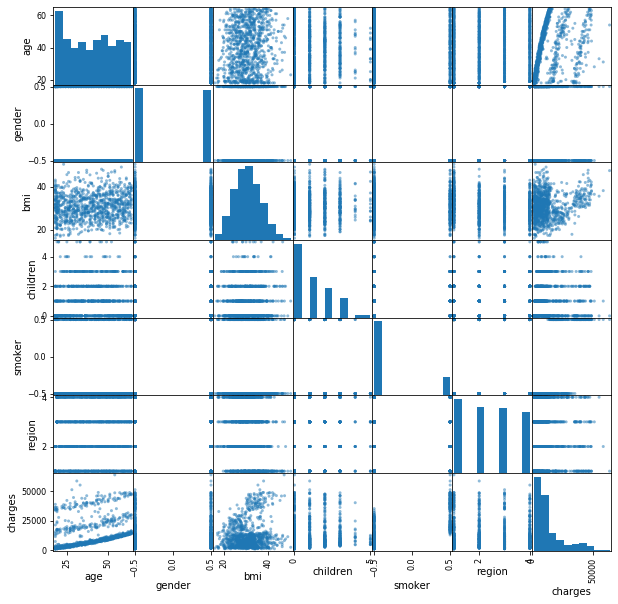

In [6]:
print(data.corr())
pd.plotting.scatter_matrix(data,diagonal = 'hist',figsize=(10,10))
plt.plot()


Visually, it can be seen that `age`, `bmi`, and `smoker` status play a large role in determining healthcare costs.

### Smoker, BMI, and age relationship with charges

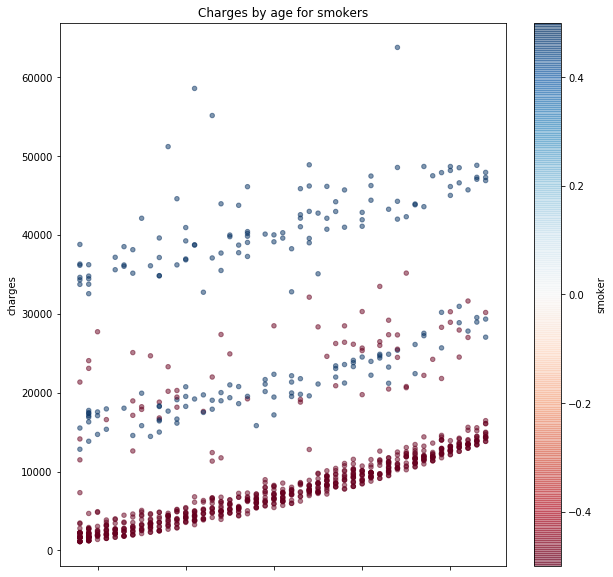

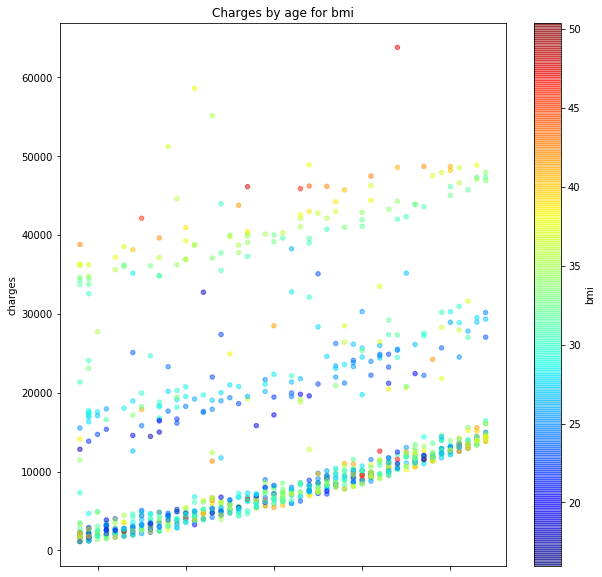

In [7]:
ax = data.plot(kind='scatter', x='age',y= 'charges', c = 'smoker', cmap ='RdBu',title='Charges by age for smokers', alpha = 0.5, figsize=(10, 10))
ax1 = data.plot(kind='scatter', x='age',y= 'charges', c = 'bmi', cmap ='jet',title='Charges by age for bmi', alpha = 0.5, figsize=(10, 10) )
plt.show()


### bmi dependence for smokers and non smokers

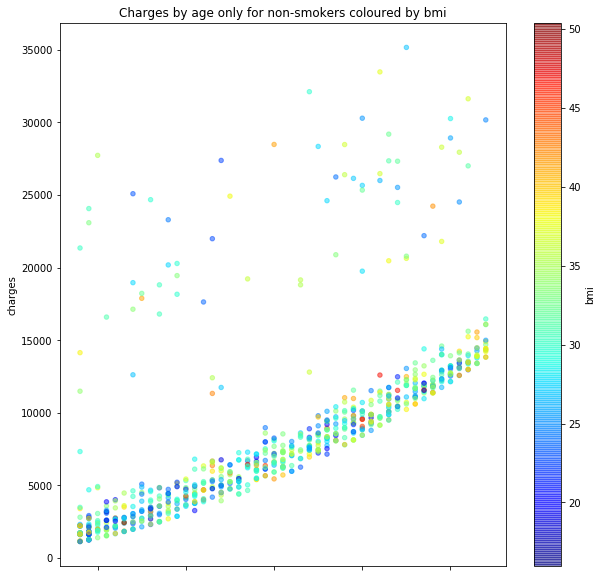

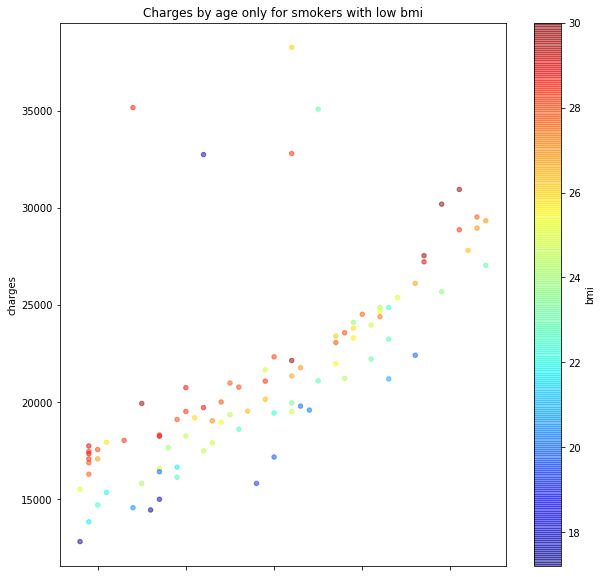

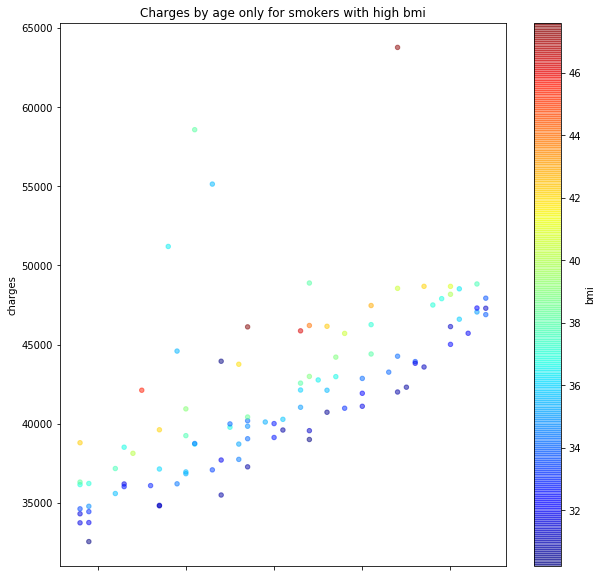

In [8]:
data[data['smoker']==-.5].plot(kind='scatter', x='age',y= 'charges', c = 'bmi', cmap ='jet',title='Charges by age only for non-smokers coloured by bmi', alpha = 0.5, figsize=(10, 10) )
data[np.logical_and(data['smoker']==.5,data['bmi']<=30)].plot(kind='scatter', x='age',y= 'charges', c = 'bmi', cmap ='jet',title='Charges by age only for smokers with low bmi', alpha = 0.5, figsize=(10, 10) )
data[np.logical_and(data['smoker']==.5,data['bmi']>30)].plot(kind='scatter', x='age',y= 'charges', c = 'bmi', cmap ='jet',title='Charges by age only for smokers with high bmi', alpha = 0.5, figsize=(10, 10) )

plt.show()

The strong dependence of `smoker` status and `bmi` on healthcare `charges` suggests a possibility of creating three different linear models, one to explain the costings associated with non-smokers, and the other to explain costings for smokers with low-bmi and costings for smokers with high bmi. The highest charges seems to be for smokers with high bmi. 

----

## Analysis pipeline API: LinRegPipe

The following cell details the class `LinRegPipe` which acts as an API for the following analysis. This API includes methods for data ingestion, transformation, model fitting, and hyperparameter tuning.

In [9]:
class LinRegPipe:
    
    def __init__(self, df):
        #consructor
        
        self.df = df
        self.preproc_dict = {}
        self.df_test = None
        self.df_train = None
        
    def convert_cat_num(self, cols, mp_dct):
        #Converts categoricals to numerical variables
        #using a mapping dictionary
        
        map_params = {'cols': cols, 'mapdicts': mp_dct}

        for col, mp in zip(cols, mp_dct):
            self.df.loc[:,col] = self.df[col].map(mp, na_action = 'ignore')

        self.preproc_dict['map'] = map_params  

    def standardize(self, cols):
        #Standardizes data to center the data around mean

        st_params = {'cols': cols, 'params': []}

        for col in cols:
            st_params['params'].append((self.df[col].mean(),self.df[col].std()))
            self.df[col] = (self.df[col] - self.df[col].mean()).div(self.df[col].std())

        self.preproc_dict['standardize'] = st_params
        
    def fit(self, df=None, target=None, alpha = 1):
        # Centered ridge regression fitting using closed form solution
        
        if df is None:
            df = self.df
        if target is None:
            target = df.columns[-1]
            
        self.target = target

        X = df.drop(target, axis=1).values
        y = df.loc[:,target].values
        I = np.identity(X.shape[1])
        self.W = np.dot( np.dot( np.linalg.inv( np.dot( X.T, X) + alpha * I), X.T), y)

    def _predict(self, X):
        #Performs predictions using fitted coefficients
        
        return(X.dot(self.W)) 
        
    def predict(self, Xtry):
        #Performs predictions and translates predicted data to original
        #space
        
        st_vals = self.preproc_dict['standardize']
        colpar = {u:v for u,v in zip(st_vals['cols'],st_vals['params'])}
        mean, std  = colpar[self.target]
        return(self._predict(Xtry)*std + mean)
    
    def score_rmse(self, y_true, y_pred):
        #Calculates root mean squared error
        
        return np.sqrt(np.mean((y_true-y_pred)**2))
    
    def score_r2(self, y_true, y_pred):
        #Calculates R squared metric
        
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        ss_reg = np.sum((y_true - y_pred)**2)
        
        return (1 - (ss_reg/ss_tot))
    
    def train_test_split(self, frac = .1):
        #Performs fractional train/test split 
        #without stratified sampling 
        
        self.df_test = self.df.sample(frac = frac)
        self.df_train = self.df.drop(self.df_test.index)
        
        return(self.df_train, self.df_test)
        
    def _crossval(self, df, alpha, leaveout = 5):
        #Performs Leave-K-Out crossvalidation
        
        df = df.reset_index(drop=True)
        max_iter = df.shape[0]//leaveout
        scores = np.zeros(max_iter)
        
        for i in range(max_iter):

            start_idx = i*leaveout
            end_idx = i*leaveout+leaveout
            
            loc_test = df.iloc[start_idx:end_idx,:]
            loc_train = df.drop(loc_test.index)
            self.fit(df = loc_train, alpha = alpha)
            scores[i] = self.score_r2(loc_test.iloc[:,-1], self._predict(loc_test.iloc[:,:-1]))
        
        return scores
              
    def _sortscores(self, score_dict):
        #Sorts crossval and testing score
        
        cv_scores = []
        test_scores = []
        
        for key,val in score_dict.items():
            cv_scores.append((key, val['cross_val']))
            test_scores.append((key, val['testing']))

        cv_scores.sort(key=lambda x:x[1],reverse = True)      
        test_scores.sort(key=lambda x:x[1],reverse = True)  
        
        return (cv_scores[0], test_scores[0]) 
        
    def hyper_tune(self, alp = None, leaveout = 5):
        #Performs hyperparameter tuning for the single
        #hyperparameter in ridge regression which is 
        #the alpha parameter
        
        if alp is None:
            alp = [0.5,1,10]
        
        tun_res = {}
        
        for alpha in alp:
            if self.df_train is None:
                crosval_res_list = self._crossval(self.df, alpha, leaveout)
            else:
                crosval_res_list = self._crossval(self.df_train, alpha, leaveout)
            
            self.fit(df = self.df_train, alpha = alpha)
            test_score = self.score_r2(self.df_test.iloc[:,-1], self._predict(self.df_test.iloc[:,:-1]))
            tun_res[alpha] = {'cross_val':np.mean(crosval_res_list), 'testing': test_score}
            
        cvs, tests = self._sortscores(tun_res) 
        
        print(f'Best CV scores are: {cvs}')
        print(f'Best testing scores are: {tests}')
        
        return tun_res  
    
    def preprocdata(self, df):
        #Preprocesses new data based on trained preprocessing steps
        
        map_params = self.preproc_dict['map']
        st_params = self.preproc_dict['standardize']
        
        for col, mp in zip(map_params['cols'], map_params['mapdicts']):
            df.loc[:,col] = df[col].map(mp, na_action = 'ignore')
            
        for col,params in zip(st_params['cols'],st_params['params']):
            df[col] = (df[col] - params[0]).div(params[1])
            
        return df
        

## Preprocessing

We will divide the dataset based on three categories that we decided on in the exploration step. Furthermore, we will instantiate the LinRegPipe class for each of the three dataset and then perform preprocessing on it. 

For narrative consistency we will load the data again. No data cleaning is being performed since the data is observed to be of high quality



In [10]:
data = pd.read_csv('train.csv')

df_nonsmo = data[data['smoker']=='no'].drop(['smoker'],axis=1).reset_index(drop=True)
df_nonsmo_cp = df_nonsmo.copy()

df_smohibmi = data[np.logical_and(data['smoker']=='yes',data['bmi']<=30)].drop(['smoker'],axis=1).reset_index(drop=True)
df_smohibmi_cp = df_smohibmi.copy()

df_smolobmi = data[np.logical_and(data['smoker']=='yes',data['bmi']>30)].drop(['smoker'],axis=1).reset_index(drop=True)
df_smolobmi_cp = df_smolobmi.copy()

cl_nonsmo = LinRegPipe(df_nonsmo)
cl_smohibmi = LinRegPipe(df_smohibmi)
cl_smolobmi = LinRegPipe(df_smolobmi)

class_list = [cl_nonsmo, cl_smohibmi, cl_smolobmi]

### Mapping categoricals to numerical variables

The main preprocessing step would be to map the categorical variables to numerical variables. We could perform OneHotEncoding for `region` but a simpler transformation is chosen here.

In [11]:
conv_maps = [ {'male':-.5,'female':.5},
             {'southeast':1,'northeast':2,'southwest':3,'northwest':4}
            ]

for cl in class_list:
    cl.convert_cat_num(['gender','region'], conv_maps)

cl_nonsmo.df.head()

,age,gender,bmi,children,region,charges
0,18,-0.5,33.770,1,1,1725.55230
1,28,-0.5,33.000,3,1,4449.46200
2,33,-0.5,22.705,0,4,21984.47061
3,32,-0.5,28.880,0,4,3866.85520
4,31,0.5,25.740,0,1,3756.62160


### Standardizing

The next preprocessing step would be to standardize the variables for input into a linear regression model. This helps to decrease the effect of leverage by features with larger magnitudes and to center the data. 

In [12]:
for cl in class_list:
    cl.standardize(cl.df.columns)

cl_nonsmo.df.head()

,age,gender,bmi,children,region,charges
0,-1.517794,-1.029669,0.479923,-0.067530,-1.306414,-1.111745
1,-0.816630,-1.029669,0.351058,1.577746,-1.306414,-0.660437
2,-0.466048,-1.029669,-1.371881,-0.890168,1.368519,2.244836
3,-0.536164,-1.029669,-0.338452,-0.890168,1.368519,-0.756965
4,-0.606281,0.969978,-0.863953,-0.890168,-1.306414,-0.775229


## Model selection

In this work, the centered ridge regression model is selected since it is a linear model with the option to perform penalized regularization using the L2 norm of the weights. The closed form solution also allows for rapid training and prototyping. 

This section will exhibit the model selection process through hyper parameter tuning of the `alpha` parameter, the Lagrange multiplier in the penalty term for ridge regularization. The data will be split into a training and testing set (without stratified sampling). The hyperparameter tuning comparison will be perfomed through a leave-K-out cross validation procedure. If low values of K is chosen in the leave-K-out cross validation process, the test set may not even be required and infact may lead to erroneous conclusions due to the non-stratified sampling. Hence, the max crossvalidation scores will be used as the deciding criteria.

In [13]:
for cl in class_list:
    #low split since the test set 
    #is not as important in this process
    cl.train_test_split(frac = .05)

### Hyperparameter `alpha` tuning

In [14]:
alp = [0.1, 1, 10, 50, 100, 200]
cl_nonsmo.hyper_tune(alp, leaveout = 5)

Best CV scores are: (50, 0.4479447637820848)
Best testing scores are: (1, 0.37127121376529393)


{0.1: {'cross_val': 0.44145912638109586, 'testing': 0.37126576706978687},
 1: {'cross_val': 0.4416691964531606, 'testing': 0.37127121376529393},
 10: {'cross_val': 0.4435619470100304, 'testing': 0.3712547041838046},
 50: {'cross_val': 0.4479447637820848, 'testing': 0.3698228464821921},
 100: {'cross_val': 0.4462080691231869, 'testing': 0.36566511555274905},
 200: {'cross_val': 0.42766827214689734, 'testing': 0.3527112526736724}}

In [15]:
alp = [0.1, 1, 10, 50, 100, 200]
cl_smohibmi.hyper_tune(alp, leaveout = 5)

Best CV scores are: (0.1, 0.48583807232848164)
Best testing scores are: (1, 0.30779539794565436)


{0.1: {'cross_val': 0.48583807232848164, 'testing': 0.3074575846283861},
 1: {'cross_val': 0.4856308468665884, 'testing': 0.30779539794565436},
 10: {'cross_val': 0.4755287996210556, 'testing': 0.30353253245468526},
 50: {'cross_val': 0.36691392705229753, 'testing': 0.2181621149255224},
 100: {'cross_val': 0.23428575873697619, 'testing': 0.10062952046159823},
 200: {'cross_val': 0.06183520573185325, 'testing': -0.06389589775920501}}

In [16]:
alp = [0.1, 1, 10, 50, 100, 200]
cl_smolobmi.hyper_tune(alp, leaveout = 5)

Best CV scores are: (1, 0.6068439919571951)
Best testing scores are: (10, 0.18123897031735603)


{0.1: {'cross_val': 0.6055880554009738, 'testing': 0.17634526177482757},
 1: {'cross_val': 0.6068439919571951, 'testing': 0.17702019080147502},
 10: {'cross_val': 0.6052332632904053, 'testing': 0.18123897031735603},
 50: {'cross_val': 0.476228452216146, 'testing': 0.17236079875230415},
 100: {'cross_val': 0.29327784553297725, 'testing': 0.14656746993932745},
 200: {'cross_val': 0.04144393702950212, 'testing': 0.10383633987765373}}

### Visualization of results

In [17]:
def visualize(df, cl, alpha, title):
    #utility function for plotting data
    cl.fit(alpha = alpha)
    plt.figure(figsize=(10, 5), dpi= 80)
    plt.scatter(x = df['age'], y = df.iloc[:,-1], label='True')
    plt.scatter(x = df['age'], y = cl.predict(cl.df.iloc[:,:-1].values), label='Predicted')
    plt.xlabel('Age')
    plt.ylabel('Charges')
    plt.title(title)
    plt.legend()
    plt.show()

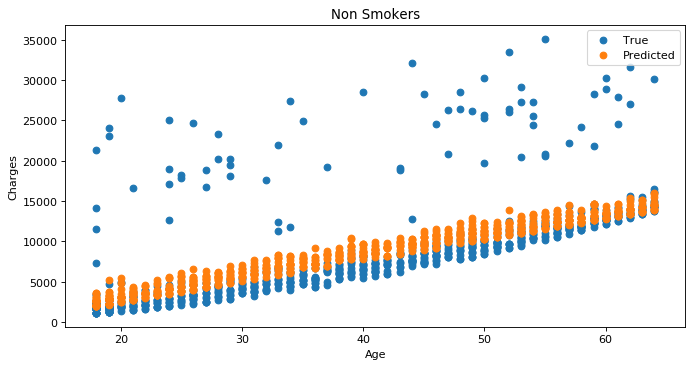

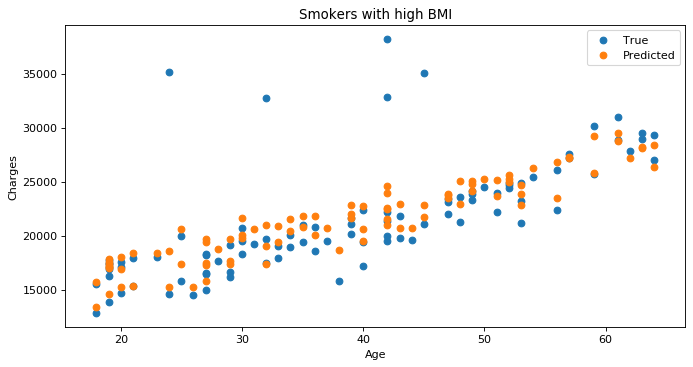

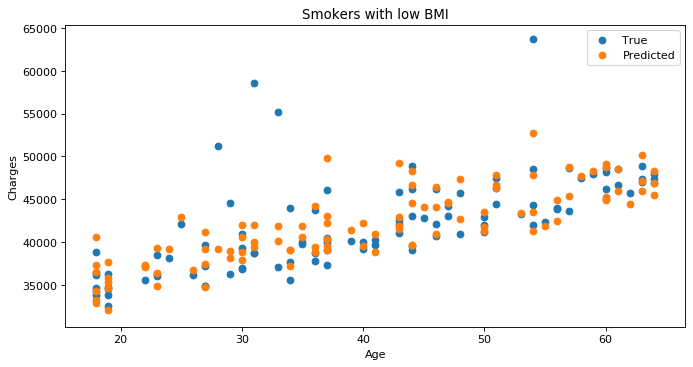

In [18]:
visualize(df_nonsmo_cp,cl_nonsmo, 50, 'Non Smokers')
visualize(df_smohibmi_cp,cl_smohibmi, 1, 'Smokers with high BMI')
visualize(df_smolobmi_cp,cl_smolobmi, 1, 'Smokers with low BMI')

## Predictions

The test data will be loaded in this section, preprocessed using the same steps as shown above, and the trained model will be used to predict `charges`.  

In [19]:
data = pd.read_csv('test_q.csv')

test_nonsmo = data[data['smoker']=='no'].drop(['smoker'],axis=1).reset_index(drop=True)
test_nonsmo_cp = test_nonsmo.copy()
test_smohibmi = data[np.logical_and(data['smoker']=='yes',data['bmi']<=30)].drop(['smoker'],axis=1).reset_index(drop=True)
test_smohibmi_cp = test_smohibmi.copy()
test_smolobmi = data[np.logical_and(data['smoker']=='yes',data['bmi']>30)].drop(['smoker'],axis=1).reset_index(drop=True)
test_smolobmi_cp = test_smolobmi.copy()

test_list = [test_nonsmo, test_smohibmi, test_smolobmi]
test_cp_list = [test_nonsmo_cp, test_smohibmi_cp, test_smolobmi_cp]

### Preprocessing of the test data 

In [20]:
for test,cl in zip(test_list, class_list):
    test = cl.preprocdata(test)

test_nonsmo.head()

,age,gender,bmi,children,region,charges
0,-1.097096,-1.029669,-0.853912,-0.890168,0.476875,NaN
1,0.585699,-1.029669,-0.217955,-0.890168,0.476875,NaN
2,0.515583,-1.029669,-1.960141,-0.067530,-0.414770,NaN
3,-0.746513,-1.029669,0.138515,0.755108,1.368519,NaN
4,-0.816630,-1.029669,-0.274857,0.755108,-0.414770,NaN


### Predicting `charges`

In [21]:
for test_cp, test, cl in zip(test_cp_list, test_list, class_list):
    test_cp['charges'] = cl.predict(test.iloc[:,:-1])
    
test_nonsmo_cp.head()

,age,gender,bmi,children,region,charges
0,24,male,25.80,0,southwest,3544.954229
1,48,male,29.60,0,southwest,9783.932068
2,47,male,19.19,1,northeast,9959.089657
3,29,male,31.73,2,northwest,5776.966476
4,28,male,29.26,2,northeast,5553.159799


### Cleaning, merging, and writing the dataframes to CSV

In [35]:
test_nonsmo_cp['smoker'] = 'no'
test_nonsmo_cp = test_nonsmo_cp[['age', 'gender', 'bmi', 'children', 'region', 'smoker','charges']]

test_smohibmi_cp['smoker'] = 'yes'
test_smohibmi_cp = test_smohibmi_cp[['age', 'gender', 'bmi', 'children', 'region', 'smoker','charges']]

test_smolobmi_cp['smoker'] = 'yes'
test_smolobmi_cp = test_smolobmi_cp[['age', 'gender', 'bmi', 'children', 'region', 'smoker','charges']]

test_cp_list = [test_nonsmo_cp, test_smohibmi_cp, test_smolobmi_cp]

In [36]:
pd.concat(test_cp_list).reset_index(drop=True).to_csv('pred.csv', index= False)